# Cavity (2D)
This notebook implements a steady incompressible Navier-Stokes solver for the cavity problem.

The problem is strong form reads:
\begin{equation}
\left\{
\begin{array}{ll}
\nabla \cdot \mathbf{u} =0& in\;\Omega\\
\displaystyle \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}= \nu\Delta \mathbf{u}-\nabla p & in\;\Omega\\ & \\
\mathbf{u} = \mathbf{i} & on\;\Gamma_{lid}\\
\mathbf{u} = \mathbf{0} & on\;\partial\Omega\setminus\Gamma_{lid}
\end{array}
\right.
\end{equation}

In [1]:
import numpy as np
import pandas as pd

# Mesh generation
import gmsh
import dolfinx
from dolfinx.io import gmshio
from mpi4py import MPI
from dolfinx.mesh import (CellType, GhostMode, create_rectangle, locate_entities_boundary)
from dolfinx.fem import Function, locate_dofs_geometrical, dirichletbc

import matplotlib.pyplot as plt
from matplotlib import cm

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

Mesh generation from *gmsh*

In [2]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = .01

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge(mesh_path+'cavity.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
bound_markers = {'lid':   10,
                 'walls': 20}

domain_marker = 100

Info    : Reading '../../../mesh/cavity.geo'...
Info    : Done reading '../../../mesh/cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00200965s, CPU 0.000675s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00728691s, CPU 0.003989s)
Info    : 10201 nodes 20404 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 1.98001e-06s, CPU 2e-06s)


The problem we want to face is non-linear, whose weak formulation reads:
\begin{equation}
\int_\Omega \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}\cdot \mathbf{v}\,d\Omega + \nu \int_\Omega\nabla \mathbf{u}\cdot \nabla \mathbf{v}\,d\Omega -\int_\Omega p(\nabla\cdot\mathbf{v})\,d\Omega -\int_\Omega q(\nabla\cdot\mathbf{u})\,d\Omega=0
\end{equation}

In [5]:
from fluid_dynamics.steady_ns import ns_steady_nl

cavity = ns_steady_nl(domain, ct = ct, ft = ft, bound_markers=bound_markers)

# ReVec = np.array([100, 400, 1000, 2500, 5000, 7500])
ReVec = np.array([100, 400, 1000])

u_list = []
boundary_type = {'lid': 0,
                 'walls': 1}
boundary_value = {'lid': np.array([1, 0, 0])}

for ii in range(len(ReVec)):
    
    cavity.parameters(1/ReVec[ii])
    cavity.set_bc(boundary_type=boundary_type, boundary_value=boundary_value)
    
    dofs_p = locate_dofs_geometrical((cavity.W.sub(1), cavity.W.sub(1).collapse()[0]), 
                                  lambda x: np.isclose(x.T, [0, 0, 0]).all(axis=1))
    cavity.bcs.append( dirichletbc(Function(cavity.W.sub(1).collapse()[0]), 
                                    dofs_p, cavity.W.sub(1)) )
#     cavity.set_cavity_bc()
    cavity.assemble(maxIter=20, verbose = False)
    
    up_sol = cavity.solve()
    (u_sol, p_sol) = (up_sol.sub(0).collapse(), up_sol.sub(1).collapse())
    u_list.append(u_sol)

Below a function to extract data from a function is implemented

In [6]:
def extract2D(problem, N, u_sol):
    grid = np.linspace(0, 1, N)
    ux = np.zeros((N,N))
    uy = np.zeros((N,N))

    for ii in range(N):
        points = np.zeros((3, N))
        points[0, :] = grid[ii]
        points[1, :] = grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        ux[ii, :] = u_sol.sub(0).eval(xPlot, cells).flatten()
        uy[ii, :] = u_sol.sub(1).eval(xPlot, cells).flatten()
    return ux.T, uy.T, grid

Let's make some 2D streamline plots

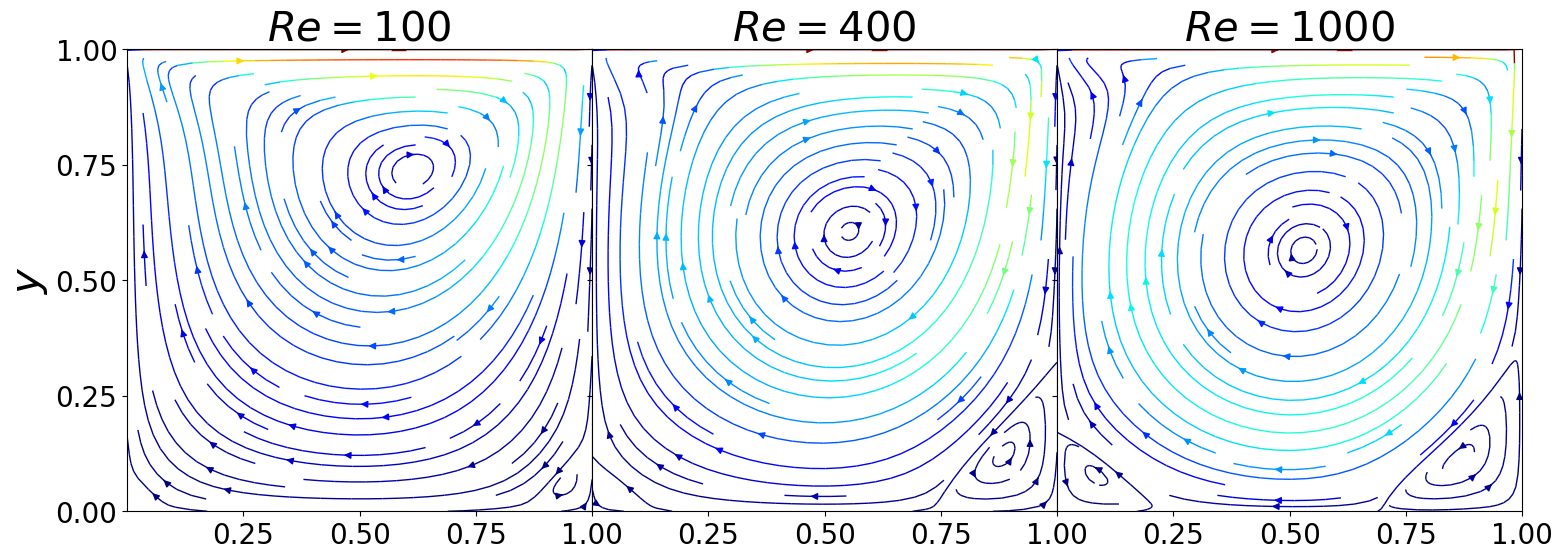

In [7]:
nrows = 1
ncols = 3

fontsize  = 30
labelsize = 20

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, 
                        figsize = (6 * ncols, 6 * nrows))
axs = axs.flatten()

N = 100

for ii in range(nrows * ncols):
    ux, uy, grid = extract2D(cavity, N, u_list[ii])
    X, Y = np.meshgrid(grid, grid)
    color = np.sqrt(((uy+2)/2)*2 + ((ux+2)/2)*2)
    
    axs[ii].streamplot(X, Y, ux, uy, color=np.sqrt(ux**2+uy**2), linewidth=1, cmap='jet')
    axs[ii].set_title(r'$Re = {:.0f}'.format(ReVec[ii])+'$', fontsize = fontsize)
    axs[ii].set_xlim(0,1)
    axs[ii].set_ylim(0,1)
    axs[ii].set_xticks(np.arange(0.25, 1.01, 0.25))
    axs[ii].set_yticks(np.arange(0., 1.01, 0.25))
    axs[ii].tick_params(axis='both', labelsize=labelsize)
    
for ii in range(3, len(ReVec)):
    axs[ii].set_xlabel(r'$x$', fontsize = fontsize)
    
axs[0].set_ylabel(r'$y$', fontsize = fontsize)
# axs[3].set_ylabel(r'$y$', fontsize = fontsize)

fig.subplots_adjust(hspace=0.1, wspace = 0)

## Comparison with benchmark data
Benchmark data are taken from https://www.acenumerics.com/the-benchmarks.html 

In [8]:
def extract1D_y(problem, N, u_sol, y_lines: list, component = 0):
    grid = np.linspace(0, 1, N)
    u_extracted = np.zeros((len(y_lines), N))

    for idx_y in range(len(y_lines)):
        points = np.zeros((3, N))
        points[0, :] = grid
        points[1, :] = y_lines[idx_y]

        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        if np.isclose(component, 0):
            u_extracted[idx_y, :] = u_sol.sub(0).eval(xPlot, cells).flatten()
        else:
            u_extracted[idx_y, :] = u_sol.sub(1).eval(xPlot, cells).flatten()
        
    return u_extracted, xPlot[:,0]

def extract1D_x(problem, N, u_sol, x_lines: list, component = 0):
    grid = np.linspace(0, 1, N)
    u_extracted = np.zeros((len(x_lines), N))

    for idx_x in range(len(x_lines)):
        points = np.zeros((3, N))
        points[0, :] = x_lines[idx_x]
        points[1, :] = grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        if np.isclose(component, 0):
            u_extracted[idx_x, :] = u_sol.sub(0).eval(xPlot, cells).flatten()
        else:
            u_extracted[idx_x, :] = u_sol.sub(1).eval(xPlot, cells).flatten()
        
    return u_extracted, xPlot[:,1]

### Vertical velocity across various horizontal planes

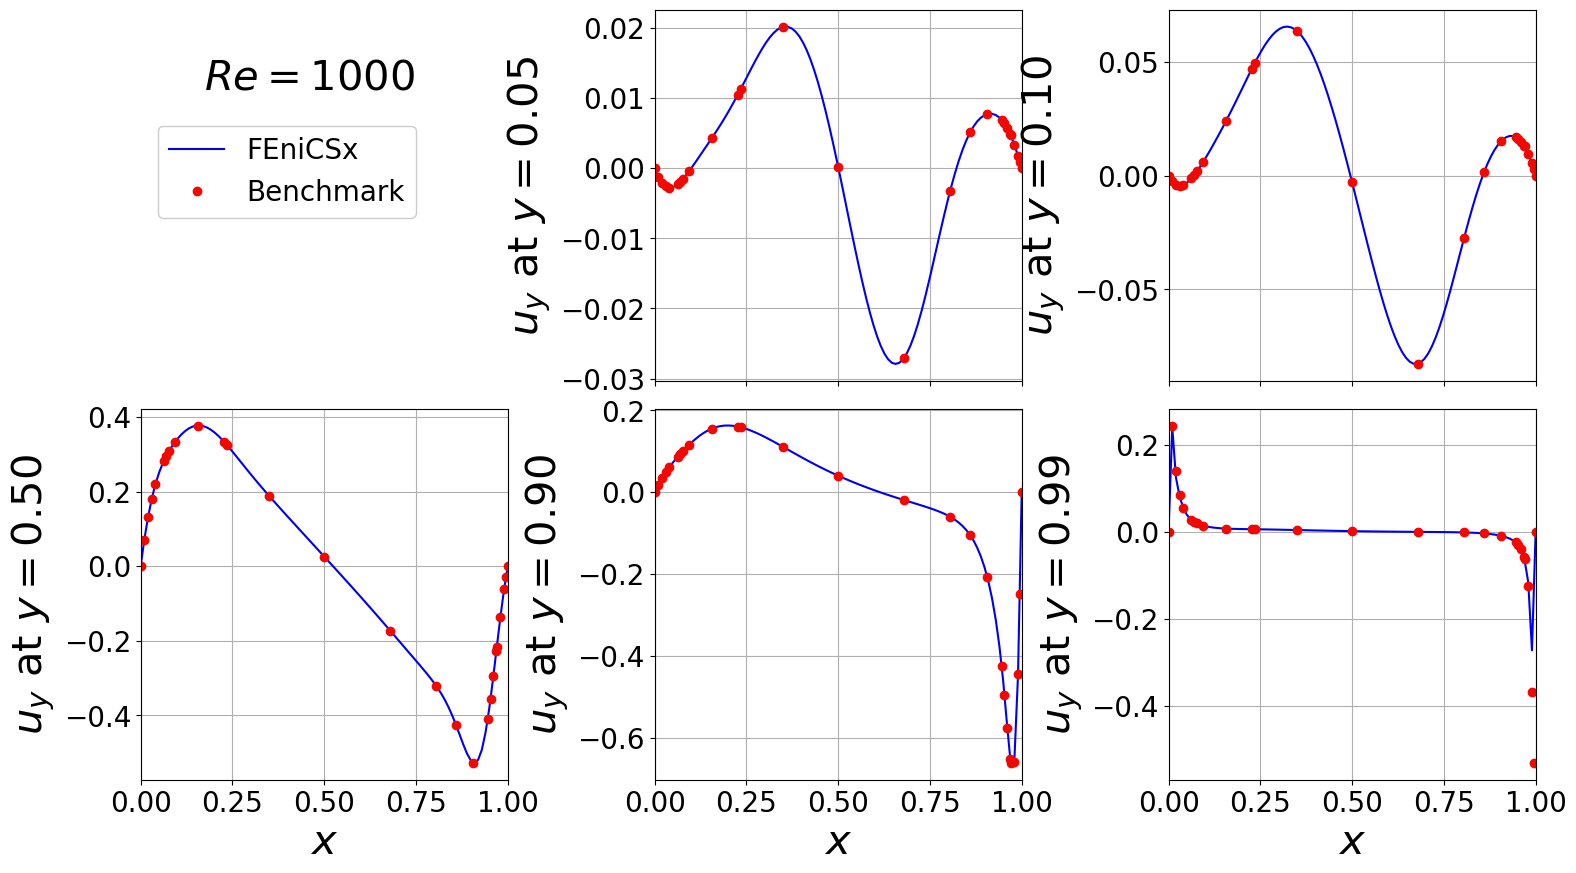

In [11]:
idx_Re = 2
df = pd.read_excel(benchmark_path+'fluid_dynamics/cavity/re_'+str(ReVec[idx_Re])+'_driven_cavity_benchmark_results.xlsx', 
                   sheet_name='Table 6')

y_lines = [0.05, 0.1, 0.5, 0.9, 0.99]

df = np.asarray(df.to_numpy())

x_bench = df[:,0].flatten()
uy_bench = df[:,1:]

del df

uy, x_plot = extract1D_y(cavity, N, u_list[idx_Re], y_lines, component = 1)

###############################################################################################

fontsize  = 30
labelsize = 20

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=True,
                        figsize = (6 * ncols, 5 * nrows))
axs = axs.flatten()

for ii in range(len(y_lines)):
    axs[ii+1].plot(x_plot, uy[ii], '-', color=cm.jet(0.1), label='FEniCSx')
    axs[ii+1].plot(x_bench, uy_bench[:, ii], 'o', color=cm.jet(0.9), label='Benchmark')
    axs[ii+1].grid()
    axs[ii+1].set_xlim(0,1)
    axs[ii+1].set_ylabel(r'$u_y$ at $y={:.2f}'.format(y_lines[ii])+'$', fontsize=fontsize)
    axs[ii+1].tick_params(axis='both', labelsize = labelsize)
    axs[ii+1].set_xticks(np.arange(0, 1.01, 0.25))
    
axs[0].axis('off')
axs[3].set_xlabel(r'$x$', fontsize=fontsize)
axs[4].set_xlabel(r'$x$', fontsize=fontsize)
axs[5].set_xlabel(r'$x$', fontsize=fontsize)

fig.text(0.16, 0.8, s=r'$Re='+str(ReVec[idx_Re])+'$', fontsize=fontsize)

Line, Label = axs[1].get_legend_handles_labels()     
fig.legend(Line, Label, framealpha = 1, fontsize=labelsize, loc=(0.1, 0.75), ncols=1)

fig.subplots_adjust(hspace=0.075, wspace=0.4)

### Horizontal velocity across various vertical planes

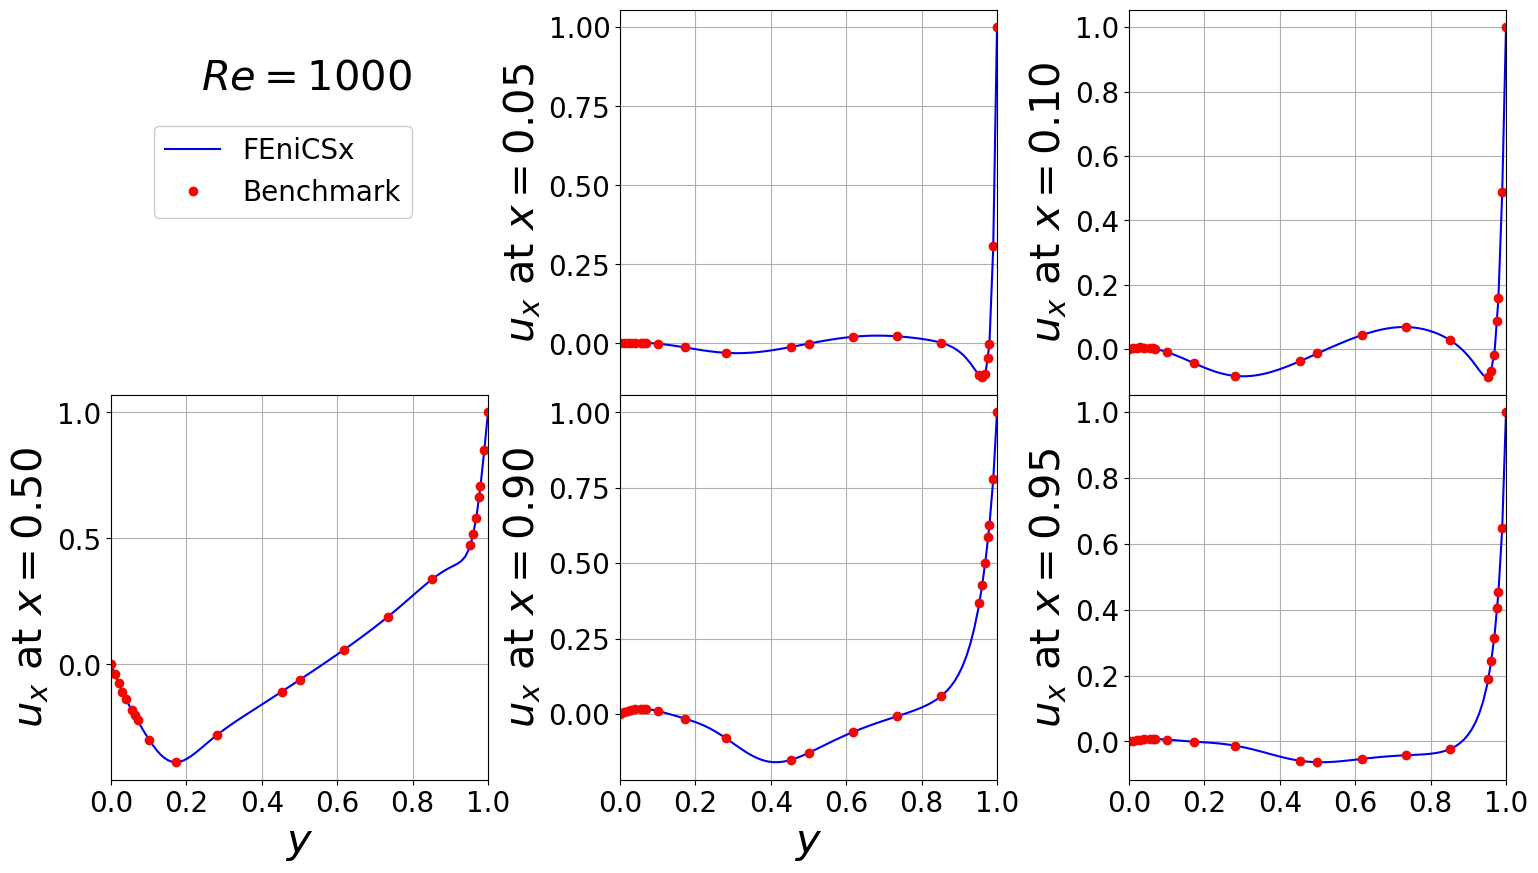

In [12]:
idx_Re = 2
df = pd.read_excel(benchmark_path+'fluid_dynamics/cavity/re_'+str(ReVec[idx_Re])+'_driven_cavity_benchmark_results.xlsx', 
                   sheet_name='Table 9')

x_lines = [0.05, 0.1, 0.5, 0.9, 0.95]

df = np.asarray(df.to_numpy())

y_bench = df[:,0].flatten()
ux_bench = df[:,1:]

del df

ux, y_plot = extract1D_x(cavity, N, u_list[idx_Re], x_lines, component = 0)

###############################################################################################

fontsize  = 30
labelsize = 20

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=True,
                        figsize = (6 * ncols, 5 * nrows))
axs = axs.flatten()

for ii in range(len(x_lines)):
    axs[ii+1].plot(y_plot, ux[ii], '-', color=cm.jet(0.1), label='FEniCSx')
    axs[ii+1].plot(y_bench, ux_bench[:, ii], 'o', color=cm.jet(0.9), label='Benchmark')
    axs[ii+1].grid()
    axs[ii+1].set_xlim(0,1)
    axs[ii+1].set_ylabel(r'$u_x$ at $x={:.2f}'.format(x_lines[ii])+'$', fontsize=fontsize)
    axs[ii+1].tick_params(axis='both', labelsize = labelsize)
    
axs[0].axis('off')
axs[3].set_xlabel(r'$y$', fontsize=fontsize)
axs[4].set_xlabel(r'$y$', fontsize=fontsize)

fig.text(0.175, 0.8, s=r'$Re='+str(ReVec[idx_Re])+'$', fontsize=fontsize)

Line, Label = axs[1].get_legend_handles_labels()     
fig.legend(Line, Label, framealpha = 1, fontsize=labelsize, loc=(0.1, 0.75), ncols=1)

fig.subplots_adjust(hspace=0.0, wspace=0.35)